# Customer Lifetime Value Prediction
- Zaman projeksiyonlu olasılıklsal lifetime value tahmini
- Öyle bir işlem yapılması gerekir ki bütün kitlenin satın alma davranışı ve bütün kitlenin işlem başına ortalama bırakacağı kazanç olasılıksal olarak modelleyelim ve bu modele yeni bir kullanıcı göndererek bir tahmin işleminde bulunalım.
- Bütün kitlenin satın alma davranışları bir olasılık dağılımı ile modellenir. Daha sonra modeli koşullu, kişi özelinde biçimlendirerek beklenen satın almayı tahmin edeceğiz.
### CLTV = Purchase Frequency * Average Order Value
### CLTV = Expected Number of Transaction * Expected Average Profit
### CLTV = BG/NBD Model * Gamma Gamma Submodel

# BG/NBD (Beta Geometric / Negative Binomial Distribution) ile Beklenen Satın Alma Sayısı
- BG-NBD satış tahmin modeli olarak kullanılır.
- Olasılık dağılımları aracılığıyla genel kitlemizin satın alma davranışlarını modelleyip kişi özeline indirgemek.
- BG-NBD modeli satın alma sürecini(transaction process) ve markayı terk etme sürecini modeller.
- Transaction Process(buy):
    - Alive olduğu sürece, belirli bir zaman periyodunda, bir müşteri tarafından gerçekleştirilecek işlem sayısı transaction rate parametresi ile poisson dağılır.
    - Bir müşteri canlı olduğu sürece kendi transaction rate'i etrafında rastgele satın alma yapmaya devam edecektir.
    - **Transaction rate'ler her bir müşteriye göre değişir ve tüm kitle için gamma dağılır. (r, a)**
- Dropout Process (till you die):
    - Her bir müşterinin p olasılığı ile dropout rate'i vardır.
    - Bir müşteri alışveriş yaptıktan sonra belirli bir olasılıkla drop olur.
    - **Dropout rate'ler her bir müşteriye göre değişir ve tüm kitle için beta dağılır (a, b)**
    

# Gamma Gamma Submodel (Expected Average Profit)
- Bir müşterinin işlem başına ortalama ne kadar kar getirebileceğini tahmin etmek için kullanılır.
- Bir müşterinin yaptığı toplam harcama, transaction value'ların ortalaması etrafında rastgele dağılır.
- Ortalama transaction value, zaman içinde kullanıcılar arasında değişebilir fakat tek bir kullanıcı için değişmez.
- Ortalama transaction value tüm müşteriler arasında gamma dağılır.

# BG-NBD ve Gamma-Gamma ile CLTV Prediction
1. Verinin hazırlanması
2. BG-NBD modeli ile expected number of transaction
3. Gamma-Gamma modeli ile expected average profit
4. BG-NBD ve Gamma-Gamma modeli ile CLTV'nin hesaplanması
5. CLTV'ye göre segmentlerin oluşturulması
6. Çalışmanın fonksiyonlaştırılması

### 1. Verinin hazırlanması

In [2]:
!pip install lifetimes

     -------------------------------------- 584.2/584.2 kB 2.6 MB/s eta 0:00:00
     ---------------------------------------- 48.9/48.9 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 110.5/110.5 kB ? eta 0:00:00


In [3]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

In [5]:
df_ = pd.read_excel("C:/Users/suley/bootcamp/crm/crm//online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [6]:
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [7]:
def outlier_threshold(dataframe, variable, q1=.01, q3=.99):
    quartile1 = dataframe[variable].quantile(q1)
    quartile3= dataframe[variable].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit =  quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe[variable] = dataframe[variable].apply(lambda x: up_limit if x > up_limit else (low_limit if x < low_limit else x))

In [8]:
# Veri Ön İşleme
df.dropna(inplace=True)
df = df.loc[~df["Invoice"].str.contains("C", na=False)]
df = df.loc[df["Price"]>0]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,12.9882,179.3316,1.0000,2.0000,6.0000,12.0000,80995.0000
Price,397885.0000,3.1165,22.0979,0.0010,1.2500,1.9500,3.7500,8142.7500
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [9]:
replace_with_thresholds(df, "Quantity")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,11.8308,25.5231,1.0000,2.0000,6.0000,12.0000,298.5000
Price,397885.0000,3.1165,22.0979,0.0010,1.2500,1.9500,3.7500,8142.7500
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [10]:
replace_with_thresholds(df, "Price")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,11.8308,25.5231,1.0000,2.0000,6.0000,12.0000,298.5000
Price,397885.0000,2.8935,3.2272,0.0010,1.2500,1.9500,3.7500,37.0600
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [11]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
today_date = df["InvoiceDate"].max() + dt.timedelta(days=2)
today_date

Timestamp('2011-12-11 12:50:00')

#### Lifetime Veri Yapısının Hazırlanması
- Recency : Son satın alma tarihi üzerinden geçen zaman. Haftalık. Müşterinin ilk satın alması ile son satın alması arasındaki süre.
- T: Müşteri yaşı. Haftalık(analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
- Frequency: Tekrar eden toplam satın alma sayısı (frequency>1)
- Monetary_value: Satın alma başına ortalama kazanç

In [12]:
cltv_df = df.groupby("Customer ID").agg({
        "InvoiceDate": [lambda x: (x.max() - x.min()).days,
                       lambda x: (today_date - x.min()).days],
        "Invoice": lambda x: x.nunique(),
        "TotalPrice": lambda x: x.sum()
        })
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000            0        327        1   310.4400
12347.0000          365        368        7  4310.0000
12348.0000          282        359        4  1770.7800
12349.0000            0         20        1  1491.7200
12350.0000            0        311        1   331.4600

In [13]:
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary"]
cltv_df

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,0,327,1,310.4400
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1770.7800
12349.0000,0,20,1,1491.7200
12350.0000,0,311,1,331.4600
...,...,...,...,...
18280.0000,0,279,1,180.6000
18281.0000,0,182,1,80.8200
18282.0000,118,127,2,178.0500


In [14]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0000,130.4486,132.0396,0.0000,0.0000,92.5000,251.7500,373.0000
T,4338.0000,224.3082,117.8865,2.0000,114.0000,250.0000,328.0000,375.0000
frequency,4338.0000,4.2720,7.6980,1.0000,1.0000,2.0000,5.0000,209.0000
monetary,4338.0000,364.1185,367.2582,3.4500,176.8512,288.2255,422.0294,6207.6700


In [15]:
cltv_df = cltv_df.loc[cltv_df["frequency"] > 1]
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.0000,28.4151,16.2667,0.0000,14.0000,29.5714,42.7143,53.2857
T,2845.0000,37.0389,14.7167,0.5714,27.5714,40.5714,51.2857,53.5714
frequency,2845.0000,5.9891,9.0442,2.0000,2.0000,4.0000,6.0000,209.0000
monetary,2845.0000,372.1736,349.3012,3.4500,191.0733,300.4873,436.8700,5724.3026


## 2. BG-NBD Modelinin Kurulması 

In [16]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df["frequency"],
       cltv_df["recency"],
       cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.44, b: 2.50, r: 2.18>

- 1 hafta içerisinde en çok satın alma beklediğimiz 10 müşteri kimdir?

In [17]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                      cltv_df["frequency"],
                                                      cltv_df["recency"],
                                                      cltv_df["T"]).sort_values(ascending=False).head(10)

Customer ID
12748.0000   3.2381
14911.0000   3.1250
17841.0000   1.9393
13089.0000   1.5322
14606.0000   1.4632
15311.0000   1.4293
12971.0000   1.3563
14646.0000   1.2025
13408.0000   0.9831
18102.0000   0.9681
dtype: float64

In [18]:
bgf.predict(1,
           cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"]).sort_values(ascending=False).head(10)

Customer ID
12748.0000   3.2381
14911.0000   3.1250
17841.0000   1.9393
13089.0000   1.5322
14606.0000   1.4632
15311.0000   1.4293
12971.0000   1.3563
14646.0000   1.2025
13408.0000   0.9831
18102.0000   0.9681
dtype: float64

In [19]:
cltv_df["expected_purchase_1_week"] = bgf.predict(1,
                                                  cltv_df["frequency"],
                                                  cltv_df["recency"],
                                                  cltv_df["T"])
cltv_df.head()

,recency,T,frequency,monetary,expected_purchase_1_week
Customer ID,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1412
12348.0000,40.2857,51.2857,4,442.6950,0.0919
12352.0000,37.1429,42.5714,8,219.5425,0.1816
12356.0000,43.1429,46.7143,3,937.1433,0.0859
12358.0000,21.2857,21.7143,2,575.2100,0.1216


- 1 ay içerisinde en çok satın alma beklediğimiz 10 müşteri kimdir?

In [20]:
bgf.predict(4,
           cltv_df["frequency"],
           cltv_df["recency"],
           cltv_df["T"]).sort_values(ascending=False).head(10)

Customer ID
12748.0000   12.9175
14911.0000   12.4661
17841.0000    7.7360
13089.0000    6.1120
14606.0000    5.8370
15311.0000    5.7017
12971.0000    5.4104
14646.0000    4.7964
13408.0000    3.9219
18102.0000    3.8617
dtype: float64

In [21]:
cltv_df["expected_purchase_1_month"] = bgf.predict(4,
                                                  cltv_df["frequency"],
                                                  cltv_df["recency"],
                                                  cltv_df["T"])
cltv_df.head()

,recency,T,frequency,monetary,expected_purchase_1_week,expected_purchase_1_month
Customer ID,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1412,0.5633
12348.0000,40.2857,51.2857,4,442.6950,0.0919,0.3664
12352.0000,37.1429,42.5714,8,219.5425,0.1816,0.7239
12356.0000,43.1429,46.7143,3,937.1433,0.0859,0.3424
12358.0000,21.2857,21.7143,2,575.2100,0.1216,0.4835


In [22]:
cltv_df["expected_purchase_1_month"].sum()

1770.6226131536384

- 3 ay içerisinde beklenen satış sayısı nedir?

In [23]:
cltv_df["expected_purchase_3_month"] = bgf.predict(12,
                                                  cltv_df["frequency"],
                                                  cltv_df["recency"],
                                                  cltv_df["T"])
cltv_df.head()

,recency,T,frequency,monetary,expected_purchase_1_week,expected_purchase_1_month,expected_purchase_3_month
Customer ID,,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1412,0.5633,1.6775
12348.0000,40.2857,51.2857,4,442.6950,0.0919,0.3664,1.0910
12352.0000,37.1429,42.5714,8,219.5425,0.1816,0.7239,2.1535
12356.0000,43.1429,46.7143,3,937.1433,0.0859,0.3424,1.0186
12358.0000,21.2857,21.7143,2,575.2100,0.1216,0.4835,1.4305


In [24]:
cltv_df["expected_purchase_3_month"].sum()

5252.035277902483

### Tahmin Sonuçlarının Değerlendirilmesi

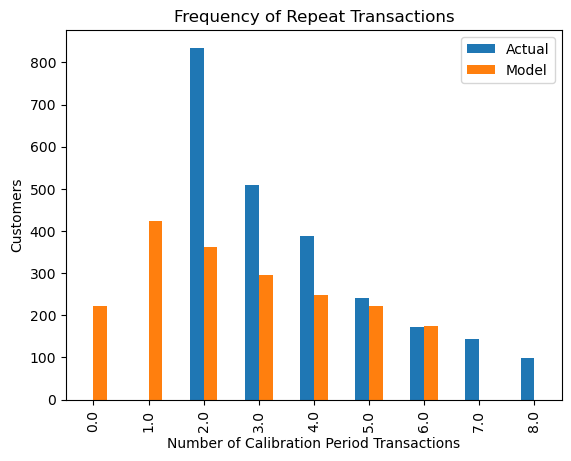

In [25]:
plot_period_transactions(bgf)
plt.show()

## 3. Gamma-Gamma Modelin Kurulması

In [26]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [27]:
ggf.fit(cltv_df["frequency"], cltv_df["monetary"])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [28]:
ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                       cltv_df["monetary"]).head()

Customer ID
12347.0000   631.9123
12348.0000   463.7460
12352.0000   224.8868
12356.0000   995.9989
12358.0000   631.9022
dtype: float64

In [29]:
ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                       cltv_df["monetary"]).sort_values(ascending=False).head()

Customer ID
12415.0000   5772.1782
12590.0000   5029.4196
12435.0000   4288.9440
12409.0000   3918.8128
14088.0000   3917.1297
dtype: float64

In [31]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                       cltv_df["monetary"])
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purchase_1_week,expected_purchase_1_month,expected_purchase_3_month,expected_average_profit
Customer ID,,,,,,,,
12415.0000,44.7143,48.4286,21,5724.3026,0.3780,1.5074,4.4883,5772.1782
12590.0000,0.0000,30.2857,2,4591.1725,0.0115,0.0458,0.1358,5029.4196
12435.0000,26.8571,38.4286,2,3914.9450,0.0759,0.3026,0.8990,4288.9440
12409.0000,14.7143,26.2857,3,3690.8900,0.1164,0.4634,1.3736,3918.8128
14088.0000,44.5714,46.1429,13,3864.5546,0.2601,1.0373,3.0876,3917.1297
18102.0000,52.2857,52.5714,60,3859.7391,0.9681,3.8617,11.5046,3870.9969
12753.0000,48.4286,52.0000,6,3571.5650,0.1257,0.5011,1.4924,3678.5783
14646.0000,50.4286,50.8571,73,3646.0757,1.2025,4.7964,14.2869,3654.8148
15749.0000,13.8571,47.5714,3,3028.7800,0.0278,0.1109,0.3300,3216.0523


## 4. BG-NBD ve GG Modeli ile CLTV'nin Hesaplanması

In [33]:
cltv = ggf.customer_lifetime_value(bgf,
                                  cltv_df["frequency"],
                                  cltv_df["recency"],
                                  cltv_df["T"],
                                  cltv_df["monetary"],
                                  time = 3, # 3 ay
                                  freq = "W", # T'nin frekans bilgisi haftalık
                                  discount_rate=0.01)

In [35]:
cltv = cltv.reset_index()
cltv.head()

,Customer ID,clv
0,12347.0000,1127.8555
1,12348.0000,538.2954
2,12352.0000,515.2097
3,12356.0000,1079.3238
4,12358.0000,961.0880


In [37]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values("clv", ascending=False).head(10)
# Düzenli olan bir müüşteri recency değeri arttıkça müşterinin satın alma olasılığı artıyordur. 

,Customer ID,recency,T,frequency,monetary,expected_purchase_1_week,expected_purchase_1_month,expected_purchase_3_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.8571,73,3646.0757,1.2025,4.7964,14.2869,3654.8148,55557.5685
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9681,3.8617,11.5046,3870.9969,47385.0930
843,14096.0000,13.8571,14.7143,17,3163.5882,0.7230,2.8729,8.4848,3196.4361,28830.9365
36,12415.0000,44.7143,48.4286,21,5724.3026,0.3780,1.5074,4.4883,5772.1782,27564.0458
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1250,12.4661,37.1429,692.3264,27361.5003
2458,17450.0000,51.2857,52.7143,46,2863.2749,0.7448,2.9711,8.8513,2874.1987,27069.0063
874,14156.0000,51.5714,53.2857,55,2104.0267,0.8741,3.4868,10.3884,2110.7542,23331.2157
2487,17511.0000,52.8571,53.5714,31,2933.9431,0.5073,2.0236,6.0289,2950.5801,18927.4448
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4778,1.9059,5.6768,2223.8850,13432.3751
650,13694.0000,52.7143,53.5714,50,1275.7005,0.7983,3.1844,9.4876,1280.2183,12923.8832


## 5. CLTV'ye Göre Segmentlerin Oluşturulması

In [40]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], q=4, labels=["D", "C", "B", "A"])
cltv_final.sample(10)

,Customer ID,recency,T,frequency,monetary,expected_purchase_1_week,expected_purchase_1_month,expected_purchase_3_month,expected_average_profit,clv,segment
138,12604.0000,26.0000,37.5714,2,127.0900,0.0771,0.3072,0.9126,141.2065,137.0677,D
2341,17227.0000,49.8571,52.8571,6,156.5533,0.1242,0.4955,1.4756,161.8560,254.1173,D
1676,15822.0000,50.8571,51.4286,2,442.7350,0.0642,0.2560,0.7620,486.8408,394.6987,C
1285,14984.0000,23.0000,26.0000,2,106.6350,0.1064,0.4234,1.2545,118.8080,158.4931,D
2799,18180.0000,19.5714,20.5714,6,307.2917,0.2500,0.9944,2.9428,317.0839,992.1372,A
326,12991.0000,12.7143,16.1429,2,251.8800,0.1428,0.5674,1.6749,277.8527,494.6745,C
2333,17204.0000,12.5714,37.8571,4,391.1400,0.0437,0.1741,0.5175,409.8529,225.6173,D
116,12567.0000,49.4286,53.0000,10,937.7720,0.1850,0.7381,2.1984,954.7122,2233.1093,A
172,12673.0000,45.8571,46.8571,2,305.2600,0.0691,0.2757,0.8201,336.3043,293.4078,C
1452,15351.0000,51.0000,53.0000,7,280.0157,0.1398,0.5574,1.6602,287.6801,508.1584,B


In [41]:
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                     recency                        T  \
               mean count           sum    mean count        sum    mean   
segment                                                                    
D        15555.7022   712 11075660.0000 22.0343   712 15688.4286 40.5106   
C        15312.4121   711 10887125.0000 30.7093   711 21834.2857 38.2029   
B        15353.1617   711 10916098.0000 29.4304   711 20925.0000 34.8348   
A        14947.0155   711 10627328.0000 31.4953   711 22393.1429 34.6022   

                         frequency             monetary                    \
        count        sum      mean count   sum     mean count         sum   
segment                                                                     
D         712 28843.5714    3.0646   712  2182 184.1492   712 131114.2023   
C         711 27162.2857    4.0956   711  2912 271.5084   711 193042.4947   
B         711 24767.5714    5.4233   711  3856 374.5919   711 266334.8306   
A         711 24602.1429   11.3769   711  8089 658.7092   711 468342.2586   

        expected_purchase_1_week                expected_purchase_1_month  \
                            mean count      sum                      mean   
segment                                                                     
D                         0.0707   712  50.3179                    0.2814   
C                         0.1202   711  85.4817                    0.4787   
B                         0.1617   711 114.9746                    0.6435   
A                         0.2728   711 193.9929                    1.0862   

                       expected_purchase_3_month                  \
        count      sum                      mean count       sum   
segment                                                            
D         712 200.3875                    0.8354   712  594.8006   
C         711 340.3902                    1.4208   711 1010.1551   
B         711 457.5536                    1.9074   711 1356.1598   
A         711 772.2913                    3.2221   711 2290.9198   

        expected_average_profit                         clv                     
                           mean count         sum      mean count          sum  
segment                                                                         
D                      199.6352   712 142140.2893  142.5686   712  101508.8668  
C                      289.7878   711 206039.1219  379.4306   711  269775.1385  
B                      395.1890   711 280979.4031  685.8463   711  487636.7313  
A                      684.6052   711 486754.2640 2214.3096   711 1574374.1353

## 6. Çalışmanın Fonksiyonlaştırılması

In [42]:
def create_cltv_p(dataframe, month=3):
    # 1. Veri Ön İşleme
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7

    # 2. BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    # 3. GAMMA-GAMMA Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final


df = df_.copy()

cltv_final2 = create_cltv_p(df)

cltv_final2.to_csv("cltv_prediction.csv")